In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import parallel_backend
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import warnings

# Set the warning filter to "ignore" to suppress all warnings
warnings.filterwarnings("ignore")

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
identity_data = pd.read_csv("train_identity.csv")
transaction_data = pd.read_csv("train_transaction.csv")

In [105]:
identity_data.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [106]:
identity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [107]:
identity_columns = identity_data.columns
print(identity_columns)

transaction_columns = transaction_data.columns
print(transaction_columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)


# Checking null value percentages

In [108]:
identity_null_percentages = pd.DataFrame((identity_data.isnull().sum()/len(identity_data))*100,columns = ['percentage'])
remove_features_identity = identity_null_percentages[identity_null_percentages['percentage']>40].index

#Columns count to be removed
print("Total count of columns to be removed:",len(remove_features_identity))

# Total number of fields
print("Total count of columns in identity data:",len(identity_null_percentages))

Total count of columns to be removed: 19
Total count of columns in identity data: 41


In [109]:
transaction_null_percentages = pd.DataFrame((transaction_data.isnull().sum()/len(transaction_data))*100,columns = ['percentage'])
remove_features_transaction = transaction_null_percentages[transaction_null_percentages['percentage']>40].index

#Columns count to be removed
print("Total count of columns tobe removed:",len(remove_features_transaction))

# Total number of fields
print("Total count of columns in transaction data:",len(transaction_null_percentages))

Total count of columns tobe removed: 192
Total count of columns in transaction data: 394


In [110]:
merged = pd.merge(transaction_data,identity_data, on = "TransactionID", how="inner")
merged.shape

(144233, 434)

In [111]:
merged_null_percentages = pd.DataFrame((merged.isnull().sum()/len(merged))*100,columns = ['percentage'])
remove_features_merged = merged_null_percentages[merged_null_percentages['percentage']>40].index

#Columns count to be removed
print("Total count of columns to be removed:",len(remove_features_merged))

# Total number of fields
print("Total count of columns in transaction data:",len(merged_null_percentages))

Total count of columns to be removed: 187
Total count of columns in transaction data: 434


In [112]:
# Removing the columns which have more than 40% null values in it
merged.drop(remove_features_merged,axis=1,inplace=True)

##### As the dataset is empty it means that we don't have any data which has more than 30% null values. Now we will check the data distribution and work on treating the null values through imputations.

In [113]:
# Separating continuous and random column names
categorical_features_merged = []

for i in merged.columns:
    if merged[i].dtype == "object":
        categorical_features_merged.append(i)

continuous_features_merged = [elem for elem in merged.columns if elem not in categorical_features_merged]

# Converting categorical data into numbers using LabelEncoders

In [114]:
# Converting all categorical information to numbers by encoding them
for column in categorical_features_merged:
    if merged[column].dtype == 'O':
        le = preprocessing.LabelEncoder()
        merged[column] = le.fit_transform(merged[column])

# Correlation Matrix

#### Need to check for 'id_28' and 'id_29'.

In [ ]:
# Removing the highly correlated columns
#identity_data.drop(['id_15','id_29','id_28','id_35'],axis=1,inplace=True)

In [14]:
# Obtaining the correlation data of identity dataset
merged_corr_matrix = merged.corr(method='pearson')

# Create a heatmap using Seaborn
# plt.figure(figsize=(220, 220))  # Optional: Adjust the figure size
# sns.heatmap(transaction_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=5)

# Add labels and title
# plt.title("Correlation Matrix For transaction data")
# plt.savefig('correlation_heatmap.png', dpi = 150, bbox_inches='tight')
# plt.show()

In [15]:
# Get pairs of highly correlated features
highly_correlated_pairs = (
    (i, j, merged_corr_matrix.loc[i, j])
    for i in merged_corr_matrix.columns
    for j in merged_corr_matrix.columns
    if i < j and  abs(merged_corr_matrix.loc[i, j]) >= 0.9
)

# Create a DataFrame to store the results
highly_correlated_df = pd.DataFrame(
    highly_correlated_pairs, columns=["Feature_1", "Feature_2", "Correlation"]
)

# Display the features with correlation greater than 0.95
highly_correlated_df.sort_values(by="Correlation",ascending=False)

,Feature_1,Feature_2,Correlation
15,C4,C6,0.999936
750,V279,V293,0.999770
55,V101,V95,0.999757
37,C12,C7,0.999454
77,V101,V293,0.999446
764,V280,V295,0.999427
384,V167,V177,0.999364
122,V103,V97,0.999331
746,V279,V95,0.999317
95,V102,V133,0.999287


In [16]:
highly_correlated_df['Feature_1'].nunique()

129

In [ ]:
# Removing the highly correlated columns [TransactionDT]
.drop(['TransactionDT'],axis=1,inplace=True)

Clearly, Transaction ID is very similar to TransactionDT as it is just its details. Hence, we are removing them. Other fields require more understanding.

# Obtaining the correlation data of identity dataset
transaction_corr_matrix = transaction_data.corr(method='pearson')

# Create a heatmap using Seaborn
plt.figure(figsize=(220, 220))  # Optional: Adjust the figure size
sns.heatmap(transaction_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=5)

# Add labels and title
plt.title("Correlation Matrix For transaction data")
plt.savefig('correlation_heatmap.png', dpi = 150, bbox_inches='tight')
plt.show()

# Get pairs of highly correlated features
highly_correlated_pairs = (
    (i, j, transaction_corr_matrix.loc[i, j])
    for i in transaction_corr_matrix.columns
    for j in transaction_corr_matrix.columns
    if i < j and  abs(transaction_corr_matrix.loc[i, j]) > 0.8
)

# Create a DataFrame to store the results
highly_correlated_df = pd.DataFrame(
    highly_correlated_pairs, columns=["Feature_1", "Feature_2", "Correlation"]
)

# Display the features with correlation greater than 0.8
highly_correlated_df

#### Now the data looks good. Proceeding to merge the data and treating null values.

# Create a distribution matrix using Seaborn's pairplot
sns.set(style="ticks")
sns.pairplot(identity_data, kind="hist", diag_kind="kde")

plt.show()

In [115]:
merged.shape

(144233, 247)

# Null value treatment

In [116]:
(merged.isnull().sum()/len(merged)).sort_values(ascending=False)

id_13             0.117262
V219              0.096816
V235              0.096816
V249              0.096816
V248              0.096816
V247              0.096816
V246              0.096816
V244              0.096816
V243              0.096816
V242              0.096816
V241              0.096816
V240              0.096816
V237              0.096816
V233              0.096816
V253              0.096816
V232              0.096816
V231              0.096816
V230              0.096816
V229              0.096816
V228              0.096816
V226              0.096816
V225              0.096816
V224              0.096816
V223              0.096816
V218              0.096816
V217              0.096816
V252              0.096816
V236              0.096816
V254              0.096816
V265              0.096816
V257              0.096816
V278              0.096816
V277              0.096816
V276              0.096816
V275              0.096816
V274              0.096816
V273              0.096816
V

In [117]:
cat_merged = merged[categorical_features_merged].fillna(merged[categorical_features_merged].mode())
cont_merged = merged[continuous_features_merged].fillna(merged[continuous_features_merged].mean())

In [118]:
# Concatenate horizontally (joining columns)
merged_imputed = pd.concat([cat_merged, cont_merged], axis=1)

In [119]:
merged_imputed.isnull().sum().sort_values(ascending=False)

ProductCD         0
V239              0
V241              0
V242              0
V243              0
V244              0
V245              0
V246              0
V247              0
V248              0
V249              0
V250              0
V251              0
V252              0
V253              0
V254              0
V255              0
V256              0
V257              0
V258              0
V259              0
V260              0
V261              0
V262              0
V263              0
V264              0
V265              0
V266              0
V267              0
V240              0
V238              0
V269              0
V237              0
V210              0
V211              0
V212              0
V213              0
V214              0
V215              0
V216              0
V217              0
V218              0
V219              0
V220              0
V221              0
V222              0
V223              0
V224              0
V225              0
V226              0


In [120]:
X = merged_imputed.drop('isFraud',axis=1)
y = merged_imputed['isFraud']

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [121]:
# Initialize and fit the logistic regression model on the training data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Now you can evaluate the model's performance using metrics like accuracy, precision, recall, etc.
# For example, using accuracy:
accuracy = logreg.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9213436405865428


# Performance of the model

In [122]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[26562    25]
 [ 2244    16]]
Precision: 0.3902439024390244
Recall: 0.007079646017699115
F1 Score: 0.013906996957844416


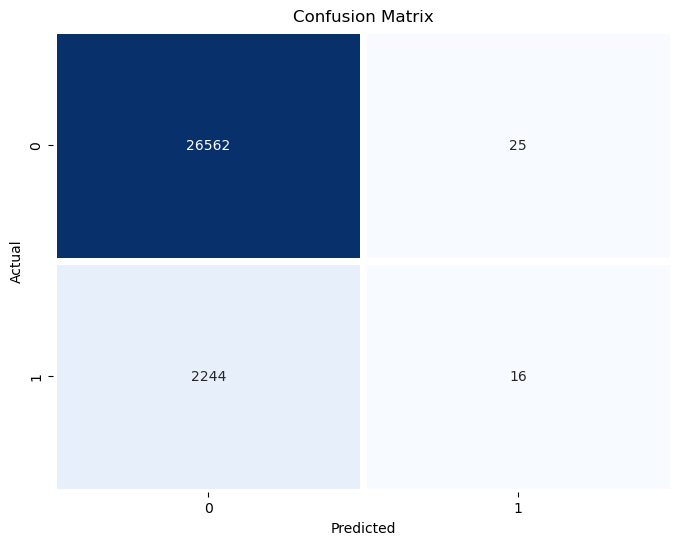

In [123]:
# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, linewidths=5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve

AUC Score: 0.6607875264077094


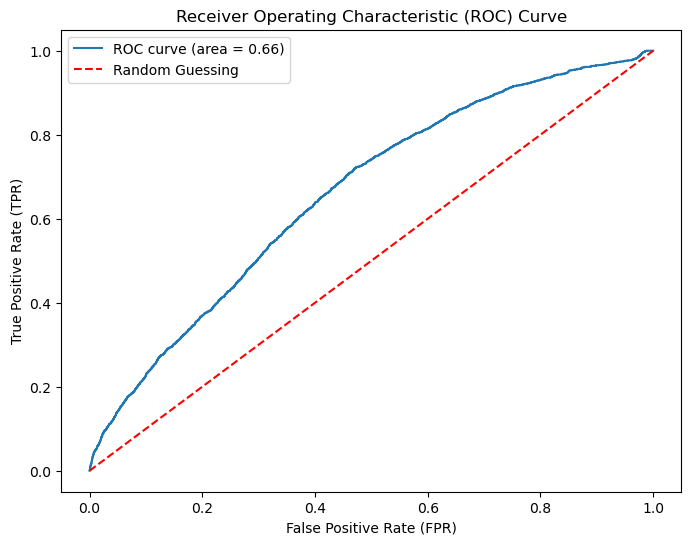

In [124]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate the fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

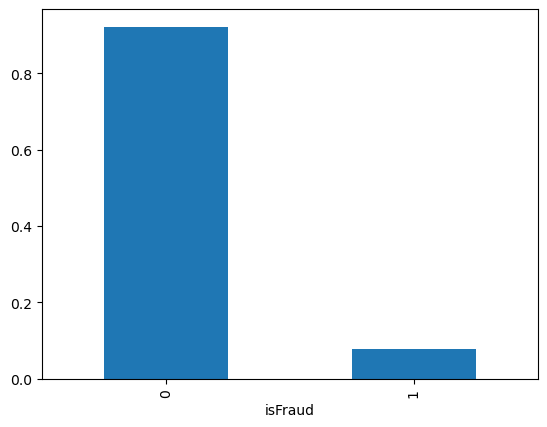

In [125]:
# Visualizing the imbalance in the dataset
temp_ser = y.value_counts(normalize=True)
temp_ser.plot(kind='bar')
plt.xlabel('isFraud')
plt.show()

#### Clearly, the data is very imbalanced and we need to improve the F-1 score to improve the model. Also, AUC curves shows that the model is not classifying the fraud cases properly as it is very close to 0.5. We need AUC scores more than 0.85 to create a better model to detect fraud cases.

Understanding data through more EDA to get better results.

We can check the VIF (Variance Inflation Factor) to check the relevance of each field. If any feature has more than 5 CIF then we can remove those features from the model. We are using VIF as a feature selection algorithm.

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature in the training set
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Display VIF for the training set
vif_train = calculate_vif(merged_imputed.drop('isFraud',axis=1))
print("VIF for the training set:")
print(vif_train)

# Identify and remove features with high VIF (e.g., VIF > 5)
high_vif_features = vif_train[vif_train["VIF"] > 5]["Variable"]
#merged_imputed_reduced = merged_imputed.drop(columns=high_vif_features)

VIF for the training set:
           Variable           VIF
0         ProductCD  7.023967e+00
1             card4  1.157399e+00
2             card6  1.202994e+00
3     P_emaildomain  1.916315e+00
4     R_emaildomain  1.628243e+00
5             id_12  2.157185e+00
6             id_15  1.162956e+02
7             id_16  1.059175e+02
8             id_28  9.734967e+01
9             id_29  9.670473e+01
10            id_31  1.894567e+00
11            id_35  1.015764e+01
12            id_36  2.941576e+00
13            id_37  2.668034e+00
14            id_38  2.116112e+00
15       DeviceType  1.950357e+00
16       DeviceInfo  1.166745e+00
17    TransactionID  3.349227e+02
18    TransactionDT  3.307356e+02
19   TransactionAmt  1.615525e+00
20            card1  1.086494e+00
21            card2  1.035260e+00
22            card3  2.287354e+00
23            card5  1.227441e+00
24               C1  7.690108e+02
25               C2  7.084276e+02
26               C3  1.161446e+00
27               C4  3

In [45]:
len(high_vif_features)

210

# Treating imbalance in the dataset

In [46]:
X = merged_imputed.drop('isFraud',axis=1)
y = merged_imputed['isFraud']

# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


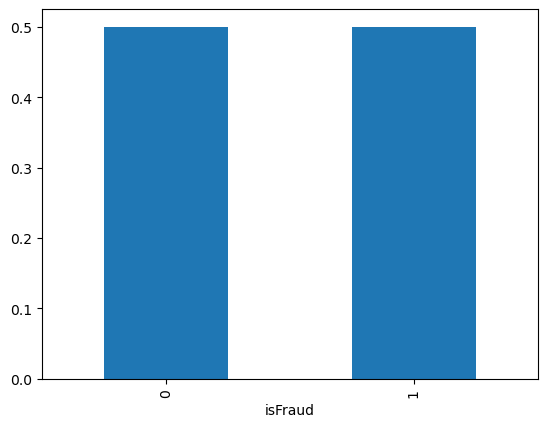

In [49]:
# Visualizing the imbalance in the dataset
temp_ser = y_resampled.value_counts(normalize=True)
temp_ser.plot(kind='bar')
plt.xlabel('isFraud')
plt.show()

In [50]:
X_resampled.shape

(265830, 246)

In [51]:
merged_imputed.shape

(144233, 247)

In [54]:
merged_imputed.drop_duplicates().shape

(144233, 247)

In [126]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Example: Balanced Random Forest
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[24280  2307]
 [  302  1958]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     26587
           1       0.46      0.87      0.60      2260

    accuracy                           0.91     28847
   macro avg       0.72      0.89      0.77     28847
weighted avg       0.95      0.91      0.92     28847



AUC Score: 0.9524453780225948


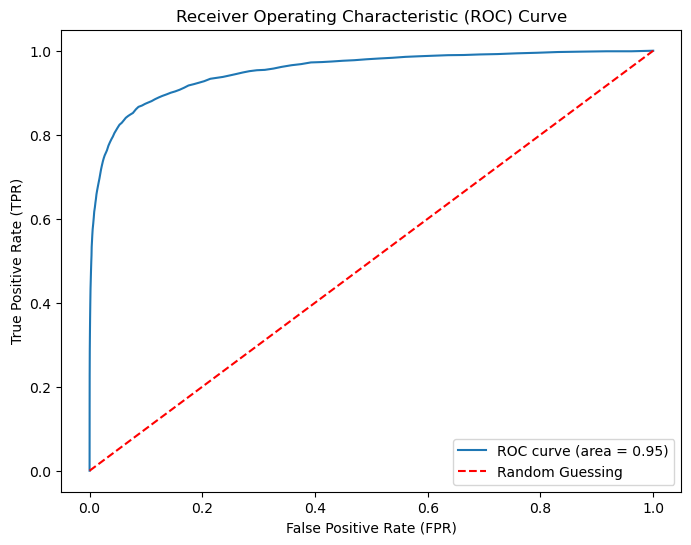

In [127]:
# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [158]:
sample = pd.read_csv("sample_submission.csv")
test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")

In [129]:
merged_test = pd.merge(test_transaction,test_identity, on = "TransactionID", how="inner")
merged_test.shape

(141907, 433)

In [130]:
merged_test.isnull().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               2497
card3               1075
card4               1158
card5               1940
card6               1080
addr1              63663
addr2              63663
dist1             141907
dist2             105479
P_emaildomain      11660
R_emaildomain       9797
C1                     3
C2                     3
C3                     3
C4                     3
C5                     3
C6                     3
C7                     3
C8                     3
C9                     3
C10                    3
C11                    3
C12                    3
C13                 1499
C14                    3
D1                  3187
D2                106854
D3                 92855
D4                 20939
D5                 86122
D6                 20866
D7                 83596
D8                 67569
D9                 67569
D10                12137


In [131]:
# Rename columns by replacing '-' with '_'
merged_test.rename(columns=lambda x: x.replace('-', '_'), inplace=True)

In [132]:
remove_features_merged

Index(['addr1', 'addr2', 'dist1', 'dist2', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       ...
       'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32',
       'id_33', 'id_34'],
      dtype='object', length=187)

In [133]:
# Removing the columns which have more than 40% null values in it
merged_test.drop(remove_features_merged,axis=1,inplace=True)

In [134]:
# Separating continuous and random column names
categorical_features_merged_test = []

for i in merged_test.columns:
    if merged_test[i].dtype == "object":
        categorical_features_merged_test.append(i)

continuous_features_merged_test = [elem for elem in merged_test.columns if elem not in categorical_features_merged_test]

In [135]:
# Converting all categorical information to numbers by encoding them
for column in categorical_features_merged_test:
    if merged_test[column].dtype == 'O':
        le = preprocessing.LabelEncoder()
        merged_test[column] = le.fit_transform(merged_test[column])

In [136]:
cat_merged_test = merged_test[categorical_features_merged_test].fillna(merged_test[categorical_features_merged_test].mode())
cont_merged_test = merged_test[continuous_features_merged_test].fillna(merged_test[continuous_features_merged_test].mean())

# Concatenate horizontally (joining columns)
merged_test_imputed = pd.concat([cat_merged_test, cont_merged_test], axis=1)

In [137]:
merged_test_imputed.isnull().sum().sort_values(ascending=False)

ProductCD         0
V239              0
V241              0
V242              0
V243              0
V244              0
V245              0
V246              0
V247              0
V248              0
V249              0
V250              0
V251              0
V252              0
V253              0
V254              0
V255              0
V256              0
V257              0
V258              0
V259              0
V260              0
V261              0
V262              0
V263              0
V264              0
V265              0
V266              0
V267              0
V240              0
V238              0
V269              0
V237              0
V210              0
V211              0
V212              0
V213              0
V214              0
V215              0
V216              0
V217              0
V218              0
V219              0
V220              0
V221              0
V222              0
V223              0
V224              0
V225              0
V226              0


In [138]:
#X_test = merged_test_imputed.drop('isFraud',axis=1)
#y_test = merged_test_imputed['isFraud']

KeyError: "['isFraud'] not found in axis"

In [139]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Example: Balanced Random Forest
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(merged_test_imputed)

In [157]:
len(y_pred)

141907